Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 200)               188800    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 200)               336600    ['input_2[0][0]']             
                                                                                              

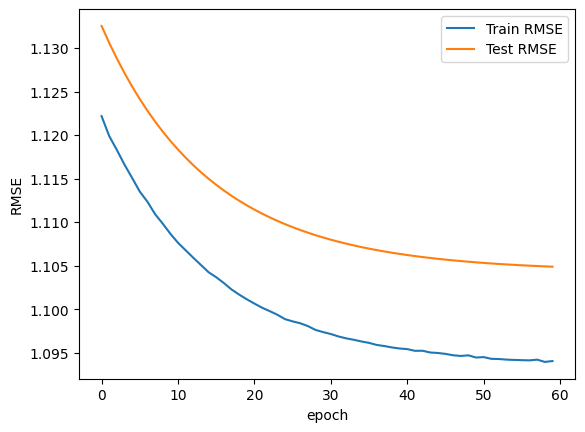

1/1 [==============================] - 0s 52ms/step
Actuals: 
        user_id  movie_id  rating
59897      741        48       4
46451      655       129       3
26300      470       246       2
7382       308       265       3
1626       279       227       4
42747      552       926       2

Predictions: 
 [[3.5566084]
 [3.3967423]
 [3.5541322]
 [3.6003206]
 [3.4747236]
 [3.4801385]]
782/782 [==============================] - 0s 293us/step


1.1055321905417306

In [1]:
# Created or modified on May 2022
# Author: 임일
# Deep learning 추천 - MF를 신경망으로 변환

import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    "./ml-100k/u.data", names=r_cols, sep="\t", encoding="latin-1"
)
ratings = ratings[["user_id", "movie_id", "rating"]].astype(int)  # timestamp 제거

# train test 분리
from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

##### (1)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# Variable 초기화
K = 200  # Latent factor 수
mu = ratings_train.rating.mean()  # 전체 평균
M = ratings.user_id.max() + 1  # Number of users
N = ratings.movie_id.max() + 1  # Number of movies


# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


##### (2)

# Keras model
user = Input(shape=(1,))  # User input
item = Input(shape=(1,))  # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)  # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)  # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(
    user
)  # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(
    item
)  # Item bias term (N, 1, )

# R = Dot(axes=2)([P_embedding, Q_embedding)
R = layers.dot([P_embedding, Q_embedding], axes=2)  # (1, 1, 1)
# R = Add()([R, user_bias, item_bias])
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)  # (1, 1)

# Model setting
model = Model(inputs=[user, item], outputs=R)
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    # optimizer=Adamax(),
    metrics=[RMSE],
)
model.summary()

# Model fitting
result = model.fit(
    x=[ratings_train.user_id.values, ratings_train.movie_id.values],
    y=ratings_train.rating.values - mu,
    epochs=60,
    batch_size=256,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values - mu,
    ),
)

# Plot RMSE
import matplotlib.pyplot as plt

plt.plot(result.history["RMSE"], label="Train RMSE")
plt.plot(result.history["val_RMSE"], label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Prediction
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print()
print("Predictions: \n", predictions)


# RMSE check
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))


user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order="C")
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)